---

# **Assigment 1: Prediction of Solubility with Logistic Regression and Neural Networks**
##### **Johan Rytved**

---


#### Imports and configurations

In [ ]:
import pandas as pd                                                   # we will use pandas to load the data as a dataframe
import matplotlib.pyplot as plt                                       # matplotlib for plotting, when we evaluate our models
import numpy as np                                                    # numpy we will use for sure as well
from tensorflow import keras
from tensorflow.keras.models import Sequential                        # Sequential model, we will be using this to build our neural network
from tensorflow.keras.layers import Dense, Dropout                    # Class for Dense (fully connected) layers in our neural network and dropout layers
from tensorflow.keras.optimizers import Adam                          # import the Adam optimizer separately so we can change the learning rate
from sklearn.linear_model import LogisticRegression                   # LogisticRegression for logistic regression
from sklearn import preprocessing                                     # sklearn.preprocessing for normalizing the data
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay  # confusion_matrix and ConfusionMatrixDisplay to make nice plots of the confusion matrices

In [ ]:
# not sure if this will work, but if i understand the docs correctly this will seed all sources of randomness, so you get the same results when running the keras model
# as i have gotten.
keras.utils.set_random_seed(42)

#### **Building a Neural Network with Keras**

Loading data. Initializing features and labels.

In [ ]:
data = pd.read_csv("https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv")
# pandas let's you read the csv directly from the an url so you actually don't need to send a get request with wget in bash or similar.
data["sol_class"] = data["measured log solubility in mols per litre"].apply(lambda x: 1 if x > 0 else 0)       # calculating the label based on the log(s)
features = data[data.columns[2:-3]].values # excluding compound ID, smiles and predicted/measured solubilities from our features
labels = data[data.columns[-1]].values # labels are the solubility classifications that we just defined, which are in the last column

In [ ]:
type(features), type(labels)  # in both cases we call the .values method to get a numpy array, since neither keras or sklearn will take a pd.DataFrame as input

(numpy.ndarray, numpy.ndarray)

#### **Scaling/normalizing the input**
There are different ways to scale the features, two of them are standard scaling and min-max scaling. In standard scaling, we subtract the mean of the feature (so we do it column-wise) and divide by the standard deviation of the feature, leading each feature to have a mean of 0 and a standard deviation of 1.

$$x_{scaled}=\frac{x-\mu_{col}}{\sigma_{col}}$$

In min-max scaling, we subtract the minimum value of the feature (again, column-wise) and divide by the range of the feature, leading each feature to have a minimum of 0 and a maximum of 1.

$$x_{scaled}=\frac{x-x_{min(col)}}{x_{max(col)}-x_{min(col)}}$$

We can use the preprocessing module from sklearn to do the normalization for both these methods. I'll do both and then just go with the one later on that gives the lowest loss for the models.

In [ ]:
stdscaler = preprocessing.StandardScaler()
features_std = stdscaler.fit_transform(features)
minmaxscaler = preprocessing.MinMaxScaler()
features_minmax = minmaxscaler.fit_transform(features)

In [ ]:
X = features_std            # we store the feature array in X
y = labels.reshape(-1,1)    # reshaping the labels to be a column vector. When we call .reshape(-1,1) we tell numpy that we want it to reshape it to 1 along the 1st dimension,
                            # and then the -1 tells it that it can reshape the 0th dimension however it wants, to make that happen.
X.shape, y.shape            # the shapes look good now, we have 1128 rows along the 0th dimension with 6 different features along the 1st dimension and one label (1 / 0) for each input.

((1128, 6), (1128, 1))

#### **Buiding the Neural Network model**
We will now use Keras/Tensorflow to build the model. We will use the Sequential model, which let's us a build a linear stack of layers. After going a bit back and forth in terms of the structure of the neural net, it seem that no configuration will keep the network from overfitting to the majority class (which i discuss further). So the settings below are just ones i ended up with after trying a bunch of different combinations. The relu function does though seems to work as a better activation function for this data. The function is very simple, outputting $0$ for $x \le 0$ and $x$ for $x > 0$.

We will use the sigmoid function in the output layer, since we are doing binary classification (labels are either 1/0) and the sigmoid will make sure to scale the output to values in that range.

In [ ]:
hl1_neurons, hl2_neurons, hl3_neurons, output_neurons = 13, 11, 9, 1      # here i store the number of neurons in the hidden and output layers,                                                         # just to make it easier to change later on...

feature_dim = X.shape[1]                                                  # the number of features in our data, the keras model needs this information

model = Sequential([                                                      # We define the model as a sequential model, and add the layers.
  Dense(hl1_neurons, activation='relu', input_shape=(feature_dim,)),
  Dense(hl2_neurons, activation='relu'),
  Dropout(0.092),                                                         # tried to add a droupout layer (randomly drops out contribution of neurons). Seems to have a positive effect on the loss...
  Dense(hl3_neurons, activation='relu'),                                  # meaning that each neuron in a layer is connected to all the neurons in the previous layer.
  Dense(1, activation='sigmoid'),                                         # The output layer should just give one output for each label, and thus gets only 1 node
])

We can use the .summary() method of the model to see if it looks as we expect. It does as, we have an output shape of (N, 4) for the hidden layers, that have 4 nodes, and (N, 1) for the output layer with one node. We can see that the feature_dim variable we passed is being used to calculate the amount of trainable parameters in the first layer. And we can see that for all the layers the amount of trainable parameters are the amount of input nodes to that layer multiplied by the amount of nodes in that layer, finally plus the amount of nodes. That is because the layer are fully connected, so we have one weight connecting each node in the layer to each in the previous. And then finally we have a bias for each node in the layer.

In [ ]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 13)                91        
                                                                 
 dense_1 (Dense)             (None, 11)                154       
                                                                 
 dropout (Dropout)           (None, 11)                0         
                                                                 
 dense_2 (Dense)             (None, 9)                 108       
                                                                 
 dense_3 (Dense)             (None, 1)                 10        
                                                                 
Total params: 363 (1.42 KB)
Trainable params: 363 (1.42 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.0087)

model.compile(                  # Before we go on, the model has to be compiled.
  optimizer=opt,                # We choose the ADAM optimizer that uses stochastic gradient descent and the learning_rate i ended up on is just what seemed to work best on this dataset.
  loss='binary_crossentropy',   # for the loss function we use binary crossentropy/log loss rather than the MSE -> tensorflow docs recommend this for binary classification.
  metrics=['accuracy'],         # choose accuracy for the metric to start with, we will calculate more metrics later on.
)

model.fit(                      # Fitting the model to data, we run 150!!! epochs with a batch size of 128-32... Weird numbers, but works the best.
  X,
  y,
  epochs=150,
  batch_size=128-32,
  class_weight={0: 1, 1: 3.08}  # this will tell the model to assign a higher weight to the positive class which is highly underrepresented in our data
)

Epoch 1/150
12/12 [==============================] - 1s 3ms/step - loss: 0.7600 - accuracy: 0.6862
Epoch 2/150
12/12 [==============================] - 0s 3ms/step - loss: 0.5947 - accuracy: 0.9415
Epoch 3/150
12/12 [==============================] - 0s 3ms/step - loss: 0.4939 - accuracy: 0.9415
Epoch 4/150
12/12 [==============================] - 0s 3ms/step - loss: 0.4147 - accuracy: 0.9415
Epoch 5/150
12/12 [==============================] - 0s 3ms/step - loss: 0.3657 - accuracy: 0.9415
Epoch 6/150
12/12 [==============================] - 0s 2ms/step - loss: 0.3245 - accuracy: 0.9433
Epoch 7/150
12/12 [==============================] - 0s 3ms/step - loss: 0.2947 - accuracy: 0.9406
Epoch 8/150
12/12 [==============================] - 0s 3ms/step - loss: 0.2603 - accuracy: 0.9326
Epoch 9/150
12/12 [==============================] - 0s 3ms/step - loss: 0.2519 - accuracy: 0.9486
Epoch 10/150
12/12 [==============================] - 0s 3ms/step - loss: 0.2408 - accuracy: 0.9300
Epoch 11/

In [ ]:
y_pred = model.predict(X)                  # Making predictions on the data...
y_pred = np.where(y_pred > 0.5, 1, 0)      # If the prediction is above 0.5, we classify it as 1, otherwise 0.
confusion_matrix(y, y_pred)

36/36 [==============================] - 0s 2ms/step


array([[1033,   29],
       [   1,   65]])

#### **Logistic Regression with sklearn**

In [ ]:
logmodel = LogisticRegression()                             # We also train a logistic regression model, to compare the performance of the neural network.
logmodel.fit(X, y.ravel())                                  # We fit the model to the training data,
y_pred_log = logmodel.predict(X)                            # and make predictions on the test data.

# NOTE: we pass y.ravel() to the logistic model, cause it will raise a warning if you pass a column vector, which we have in y.
# It will still work if you pass y, but it's just nice to supress the warning. The only difference between y and y.ravel()
# is that .ravel() flattens the array into one dimension, see:
y.shape, y.ravel().shape

((1128, 1), (1128,))

# Evaluating the models

In the upcoming part, i will create confusion matrices for the predictions made on the dataset by the logistic regression, keras neural network and
a null-model that just predicts 0 for all samples.

The confusion matrix is a  $2*2$ sized matrix, where we based on predicted and true labels can see the amount of true positives, false positives, true negatives and false negatives.

Based on the numbers, we can compute four parameters for evaluating the performance of the model. These are the accuracy, precision, sensitivity and specificity. The definitions of these parameters are as follows:

$$Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$$

$$Precision = \frac{TP}{TP + FP}$$

$$Sensitivity = \frac{TP}{TP + FN}$$

$$Specificity = \frac{TN}{TN + FP}$$

In [ ]:
cm_nn = confusion_matrix(y, y_pred)
cm_logreg = confusion_matrix(y, y_pred_log)
cm_null_model = confusion_matrix(y, np.zeros(y.shape[0])) # this is the null model, it's just an array of zeros in the shape of our output.

models = [cm_nn, cm_null_model, cm_logreg]

"""
The confusion matrix looks like this:
          PRED
            0    1
  TRUTH   0 [TN, FP]
          1 [FN, TP]

So we can access the values in the matrix by their indices, and calculate the different metrics.
"""

# let's just do all the calculations manually using the confusion matrices, instead of the sklearn.metrics functions
# sklearn.metrics has functions to calculate the accuracy and precision, but not sensitivity and specificity,
# so we might as well do the calculations in a consistent way

tinyfloat = 0.00001 # I'm adding this tiny number to the denominators to not get divisionbyzero error in the case that will arise that the denominator is 0.

accuracies = [(model[0,0] + model[1,1]) / (np.sum(model)+tinyfloat) for model in models]
precisions = [model[1,1] / (model[1,1] + model[0,1] + tinyfloat) for model in models]
sensitivities = [model[1,1] / (model[1,0] + model[1,1] + tinyfloat) for model in models]
specificities = [model[0,0] / (model[0,0] + model[0,1] + tinyfloat) for model in models]


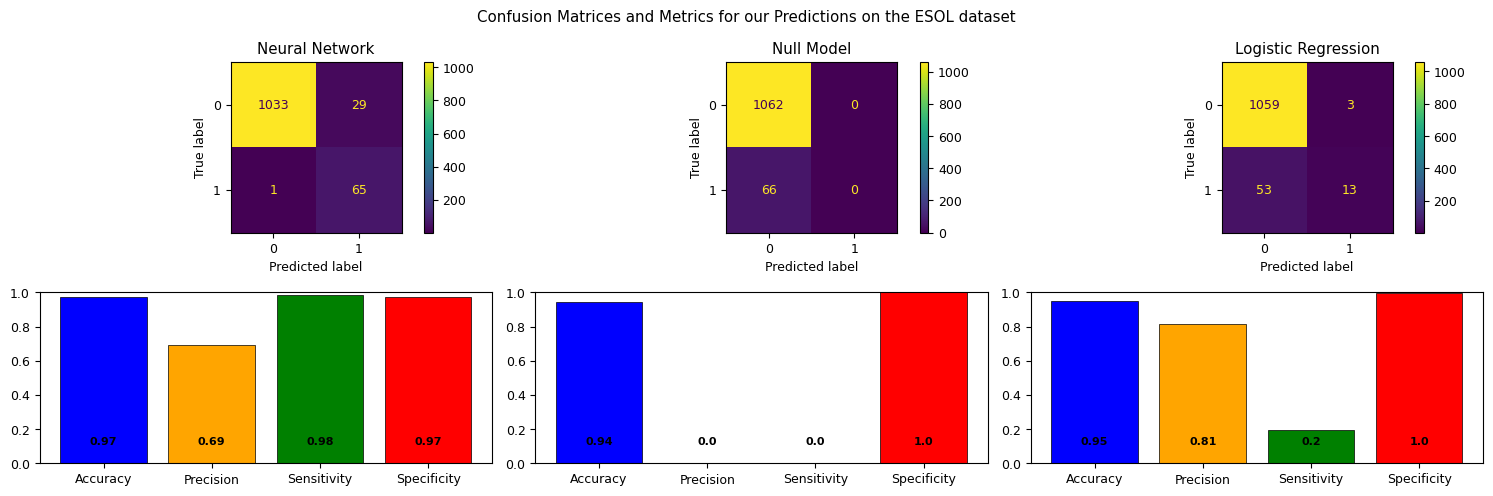

In [ ]:
plt.rcParams.update({'font.size': 9})               # decreasing the font size a bit so it doesn't look horrible

fig, ax = plt.subplots(2,3, figsize=(15,5))         # We will plot the confusion matrix and classification report for the predictions on the test data

ax[0][0].set_title("Neural Network")
ConfusionMatrixDisplay(cm_nn).plot(ax=ax[0][0])     # display the confusion matrix nicely with ConfusionMatrixDisplay from sklearn

ax[0][1].set_title("Null Model")
ConfusionMatrixDisplay(cm_null_model).plot(ax=ax[0][1])

ax[0][2].set_title("Logistic Regression")
ConfusionMatrixDisplay(cm_logreg).plot(ax=ax[0][2])


axises=[ax[1][0], ax[1][1], ax[1][2]]

for acc, prec, sens, spec, axis in zip(accuracies, precisions, sensitivities, specificities, axises): # for each model, let's plot the metrics that we calculate previously in a bar plot
    axis.bar(["Accuracy", "Precision", "Sensitivity", "Specificity"], [acc, prec, sens, spec], color=["blue", "orange", "green", "red"], linewidth=0.5, edgecolor="black")
    # let's also add the actual value of each metric to the bars

    axis.text(0, 0.1, round(acc, 2), ha="center", va="bottom", color="black", fontsize=8, fontweight="bold")
    axis.text(1, 0.1, round(prec, 2), ha="center", va="bottom", color="black", fontsize=8, fontweight="bold")
    axis.text(2, 0.1, round(sens, 2), ha="center", va="bottom", color="black", fontsize=8, fontweight="bold")
    axis.text(3, 0.1, round(spec, 2), ha="center", va="bottom", color="black", fontsize=8, fontweight="bold")

for axis in axises:
  axis.set_ylim(0,1)

plt.suptitle("Confusion Matrices and Metrics for our Predictions on the ESOL dataset")
plt.tight_layout()


#### **Comments on the results**

***Note: The confusion matrix of the neural network seems to depend quite highly on the random weight initialization, so if the text below doesn't make sense with the plot above, please run the fit of the keras model again.***

Here's what the confusion matrices look like as i am looking at them:

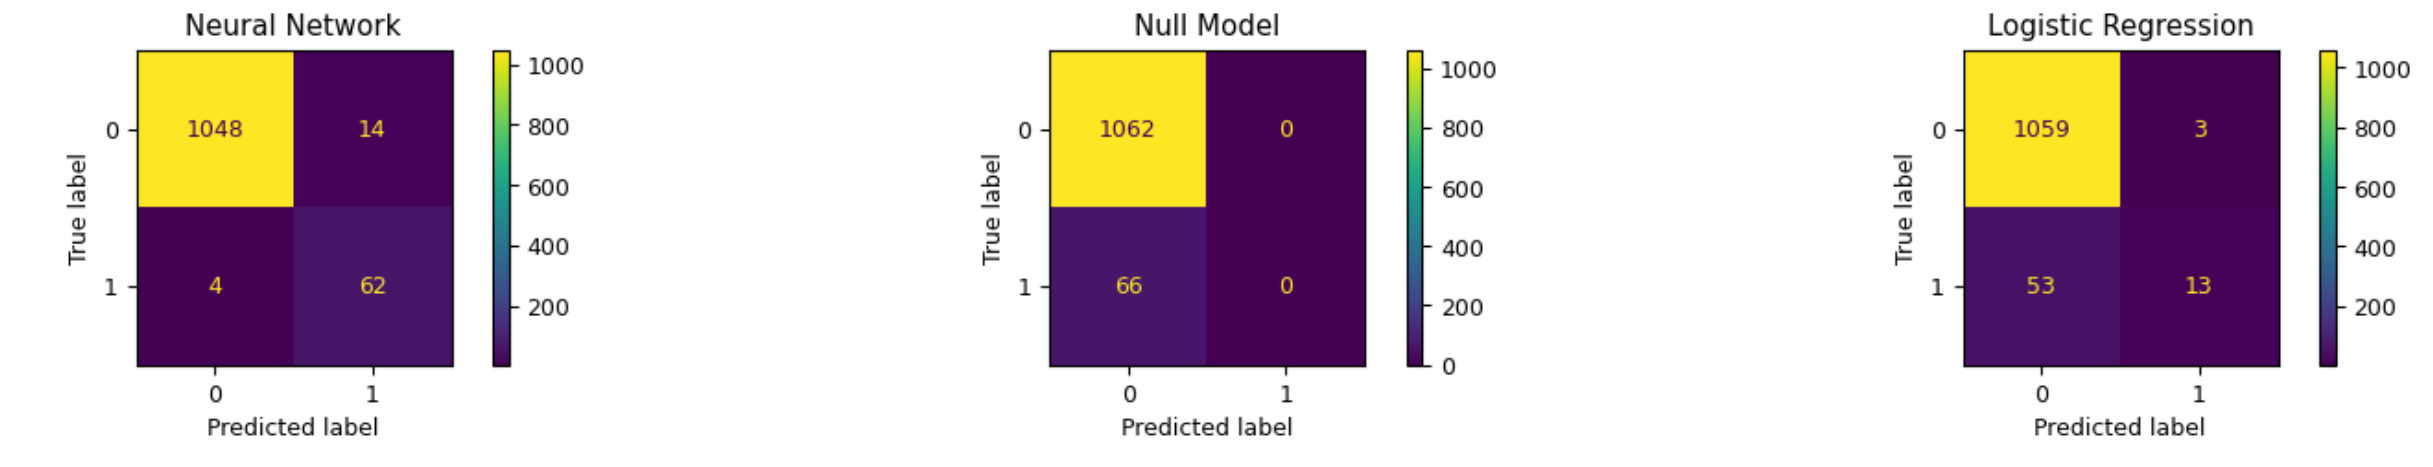

**ACCURACY**

For our accuracies we are calculating $(TP + TN) / (TP + TN + FP + FN)$. So we are esentially calculating the fraction of correct predictions.
The null model just predicts 0 for everything, and since most labels are 0 they are correct around 96% of the time. This is
just due to the skewed nature of the data, and not because we have a good model. The logistic regression model also predicts 0 for most labels,
but also has a one or a few true negatives, and thus has a slightly higher accuracy. The keras neural network has a very high accuracy (.99) since it both has a good true negative and true positive rate. It also has a few false positives, though.

**PRECISION**

For our precisions we are calculating $TP / (TP + FP)$ and since the null model predicts 0 for everything we are dividing by zero,
and get nan. The logistic regression has made a quite few true positives and a couple false positives. So it has a decent precision of around 0.8. The neural network has a precision around .83, so slightly better than the logistic regression, because it has more True positives in comparison with a few false positives.

**SENSITIVTY**

For our sensitivities we are calculating $TP / (TP + FN)$. The null model predicts 0 for everything, so it has 0 true positives, and thus a sensitivity of 0. The logistic regression has a couple of true positives, and a few false negatives, ending up with a sensitivity of just above 0.2. The neural net has a very high sensitivy (.98) because there is only af ew false negative buts a lot of true positives.

**SPECIFICITY**

For our specificities we are calculating $TN / (TN + FP)$. The null model has many true negatives/it never predicts 1, so there are zero false positives to go in the denominator, and thus the specificity is 1.0. So here the null model gets a good metric again, even though its actually a  bad model.

As the logistic regression has made few false positives, and many true negatives, it also has a specificity close to 1.

The keras model has a good specificity as well (.99) because it makes only a few false positives, but a lot of true negatives.

#### **Looking at class imbalance in the dataset before final comments**

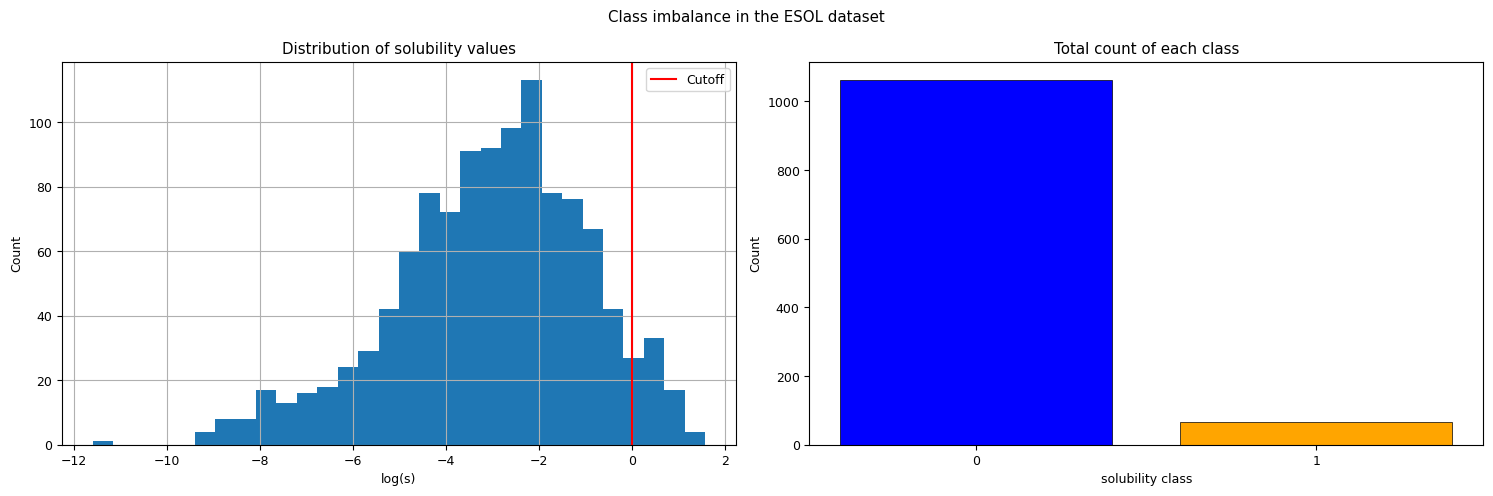

In [ ]:

fig, ax = plt.subplots(1,2, figsize = (15,5))

data["measured log solubility in mols per litre"].hist(bins=30, ax=ax[0])     # making a histogram of the solubility values
ax[0].set_xlabel("log(s)")
ax[0].set_ylabel("Count")
ax[0].set_title("Distribution of solubility values")
ax[0].axvline(0, label = "Cutoff", c="r")
ax[0].legend()

ax[1].bar(["0", "1"], [np.sum(data["sol_class"] == 0), np.sum(data["sol_class"] == 1)], color=["blue", "orange"], linewidth=0.5, edgecolor="black") # bar plot of count of classes
ax[1].set_xlabel("solubility class")
ax[1].set_ylabel("Count")
ax[1].set_title("Total count of each class")

plt.suptitle("Class imbalance in the ESOL dataset")

plt.tight_layout()


#### **Final comments on the model performance**

If we look at the distribution of labels across the dataset, it is clear that the dataset is skewed towards low solubility values.
Only 66 compounds have a solubility value above 0, while 1062 have a solubility value below 0.

The logistic regression model is performing okay, because it doesn't simply predict 0 for all features. But it has a lot of false negatives, and thus seems to be also to be skewed towards predicting the majority class.

We see that there are 66 examples of solubility values above 0 in the test data, and the logistic regression model has predicted 13
of these correctly. So it is able to predict solubility values above 0, but not very well, because that's obviously not a great success rate.

**Why is accuracy a bad metric for our case?**

Accuracy is not a good metric for binary classification when the dataset is skewed towards one class. This is because the model can achieve
a high accuracy by simply predicting the majority class for all samples and get a good score, without actually learning anything about the minority class. This is exactly what we see for the null model, which if we only looked at the numbers for accuracy and specificity, would have thought to be a good model.

**Which model works best?**
In our case you the keras neural net is still performing the best. It has only a few false negatives. it is performing well on all our metrics: accuracy, precision, sensitivity and specificity! It's lowest metrics is accuracy, affected by the fact that it still makes quite a few false positives.

But it is noteworthy that the performance is very dependent on the random weight initialization. If you try to run it 10 times, the confusion matrix will look a quite a bit different each time, so our model is not very stable.